In [589]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from cnocr import CnOcr
import re
def fillColor(img,color=[255, 255, 255]):
    # 计算填充的大小
    radio=0.05
    top = int(radio * img.shape[0])
    bottom = int(radio * img.shape[0])
    left = int(radio * img.shape[1])
    right = int(radio * img.shape[1])
    # 调用cv2.copyMakeBorder()函数进行填充
    img_with_border = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return img_with_border
def show(dilate, title,cmap=None,debug=False):
    if debug:
        plt.title(title)
        plt.imshow(dilate,cmap=cmap)
        plt.show()
def getIdcard(ori_img,debug=False):
    matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
    matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    show(ori_img,"原始图",debug=debug)
    #使用第一个像素点填充10%大屏到外围，防止图片边框没有闭合
    rgb = ori_img[0, 0]
    img = fillColor(ori_img, [126, 126, 138])
    show(img,"填充图",cmap="gray",debug=debug)
    #%%
    #转换成灰度图
    grayImg=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    show(grayImg,"灰度图",cmap="gray",debug=debug)
    grayImg=cv2.medianBlur(grayImg,7)
    # grayImg=cv2.GaussianBlur(grayImg,(5,5),0,0)
    show(grayImg,"高斯降噪图",cmap="gray",debug=debug)
    """
    二值处理，非黑即白。这里通过cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU，使用OpenCV的大津法二值化，对图像进行处理，经过处理后的图像，更加清晰的分辨出了背景和身份证的区域。
    """
    _,dst=cv2.threshold(grayImg,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    show(dst, "二值化图",cmap="gray",debug=debug)
    #dst=cv2.adaptiveThreshold(grayImg,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,3)
    kernel = np.ones((3, 3), np.uint8)
    #進行开运算，腐蚀掉噪点，然后进行膨胀
    morph_open = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)
    show(morph_open,"morph_open開運算",cmap="gray",debug=debug)
    # 将图像中的目标物体（白色）膨胀（变大），同时减小目标物体与背景（黑色）之间的距离
    dilate = cv2.dilate(morph_open, kernel, iterations=5)
    show(dilate, "膨胀",cmap="gray",debug=debug)
    canny = cv2.Canny(dilate, 100, 150)
    show(canny,"canny边框图",cmap="gray",debug=debug)
    dilateImg = cv2.dilate(canny, kernel, iterations=5)
    show(dilateImg,"canny边框膨胀",cmap="gray",debug=debug)
    # morph_close = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, kernel)
    # show(morph_close,"canny边框膨胀后腐蚀",cmap="gray",debug=debug)
    #轮廓检测
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    show(cv2.drawContours(img.copy(), contours, -1, (0, 0, 255), 3),"绘制边框",debug=debug)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[0]
    image_copy = img.copy()
    res = cv2.drawContours(image_copy, contours, -1, (255, 0, 0), 3)
    show(res, "contours",debug=debug)
    approx = cv2.approxPolyDP(contours, 0.05 * cv2.arcLength(contours, True), True)
    image_copy = img.copy()
    cv2.drawContours(image_copy, [approx], 0, (0, 255, 0), 3)
    show(image_copy, "contours矩形",debug=debug)
    #获取最大边框的坐标
    x,y,w,h = cv2.boundingRect(approx)  
    roi = img[y:y+h, x:x+w]
    if w < h:
        roi = np.rot90(roi)
    return roi;
def get_data_areas(img,isDebug):
    grayImg=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resize = cv2.resize(grayImg, (1084, 669), interpolation=cv2.INTER_AREA)
    gray = resize.copy()
    threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    show(threshold, "threshold",cmap="gray",debug=isDebug)
    blur = cv2.medianBlur(threshold, 5)
    kernel = np.ones((3, 3), np.uint8)
    #進行開運算
    morph_open = cv2.morphologyEx(blur, cv2.MORPH_OPEN, kernel)
    kernel = np.ones((7, 7), np.uint8)
    dilate = cv2.dilate(morph_open, kernel, iterations=6)
    show(dilate, "获取开运算膨胀土",cmap="gray",debug=isDebug)
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    resize_copy = resize.copy()
    res = cv2.drawContours(resize_copy, contours, -1, (255, 0, 0), 2)
    show(res, "绘制边框",cmap="gray",debug=isDebug)
    data_areas = []
    resize_copy = resize.copy()
    for contour in contours:
        epsilon = 0.002 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        x, y, w, h = cv2.boundingRect(approx)
        if h > 50 and x > 150 and x < 620:
            res = cv2.rectangle(resize_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
            data_area = gray[y:(y + h), x:(x + w)]
            show(data_area,"原始图",cmap="gray",debug=isDebug)
            data_area = cv2.resize(data_area, (int(w+0.3*w), int(h+0.3*h)), interpolation=cv2.INTER_AREA)
            show(data_area,"扩大",cmap="gray",debug=isDebug)
            # data_area1=cv2.medianBlur(data_area1,7)
            # _,data_area1=cv2.threshold(data_area1,0,255,cv2.THRESH_OTSU)
            # show(data_area1,"二值化",cmap="gray",debug=True)
            # # 自适应直方图均衡化
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2,2))
            data_area = clahe.apply(data_area)
            show(data_area,"直方图处理",cmap="gray",debug=isDebug)
            # show(data_area,"原图",cmap="gray",debug=True)
            data_areas.append((x, y, w, h,data_area))    
    data_areas = sorted(data_areas, key=lambda x: x[1])
    return data_areas  

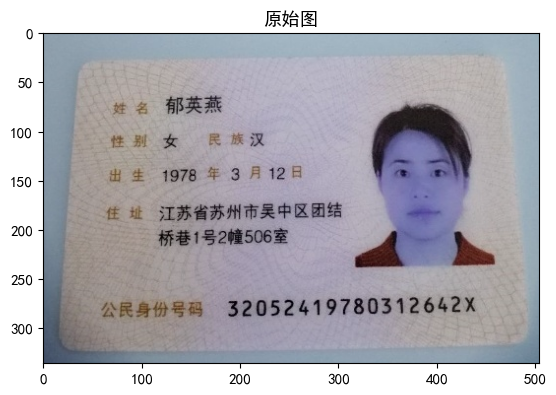

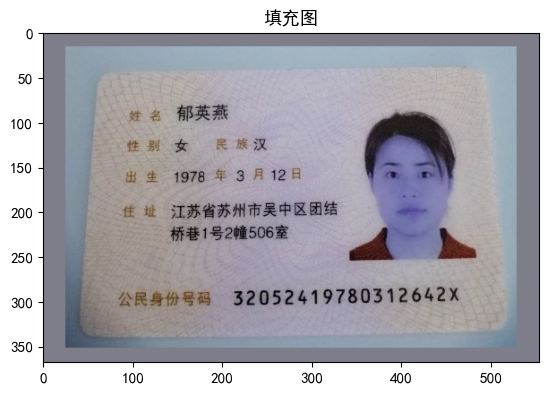

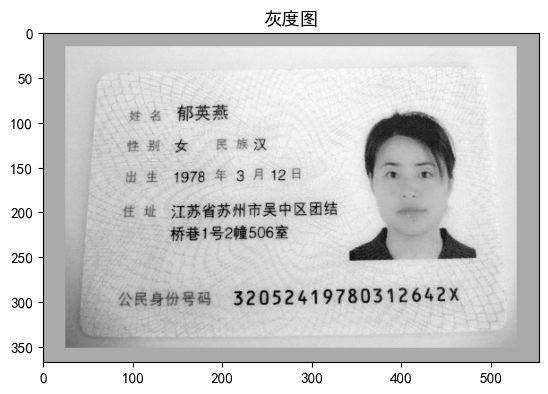

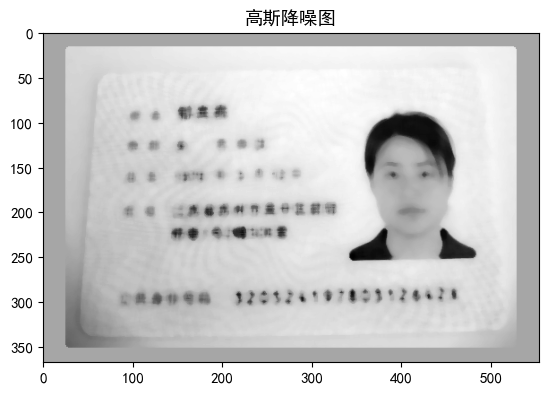

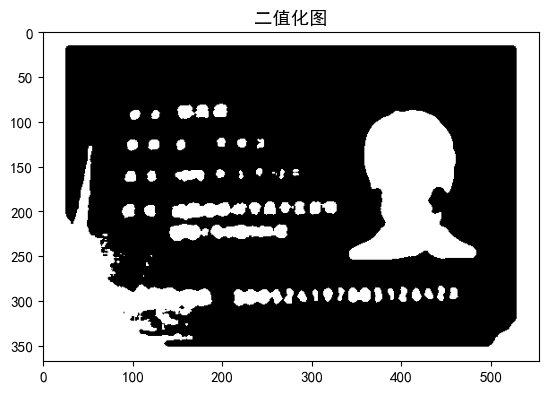

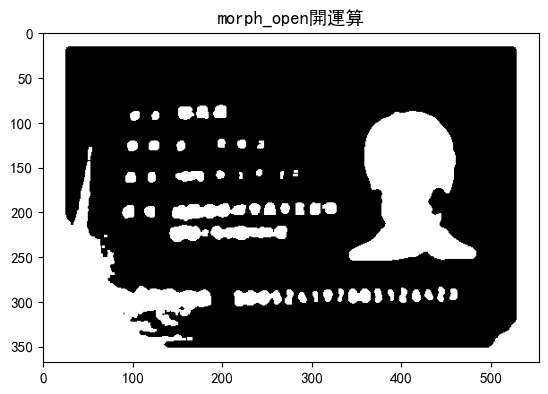

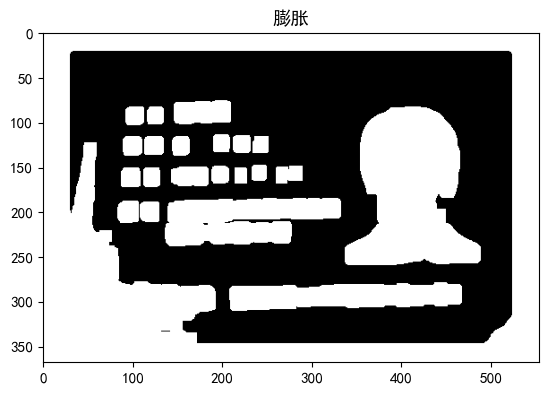

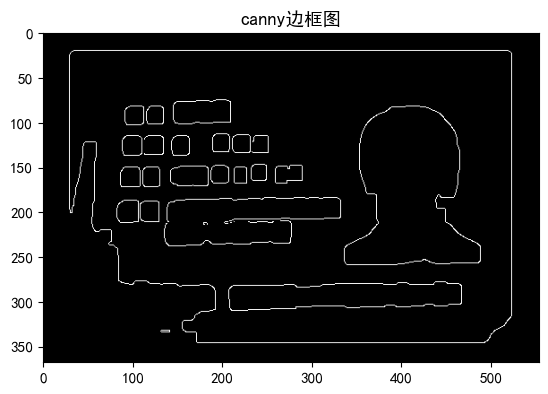

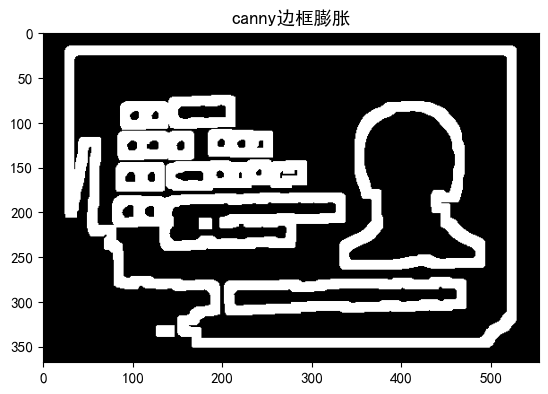

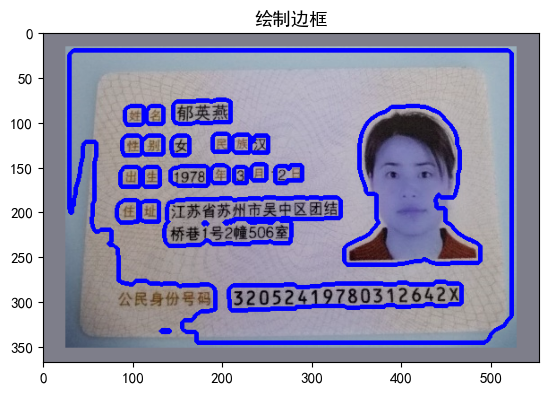

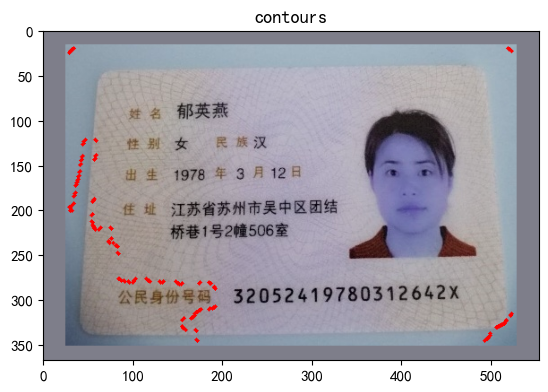

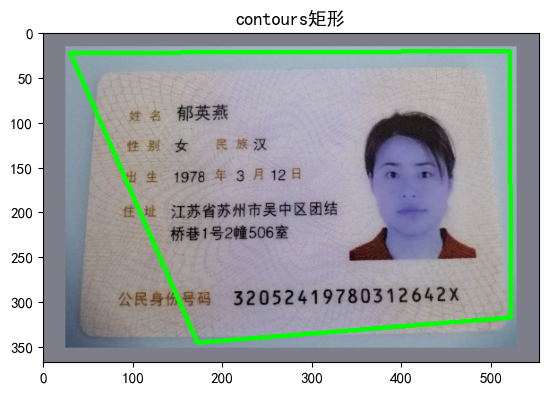

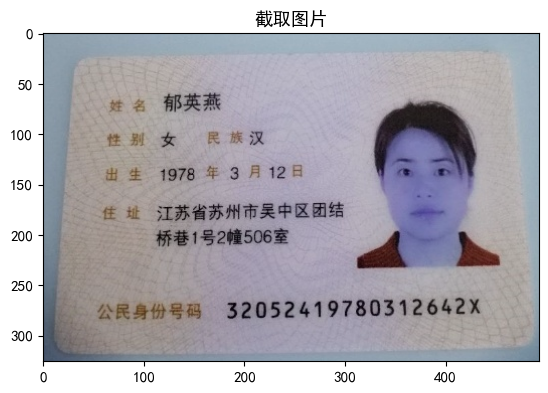

拉普拉多 424.22406924703233
{'姓名': '郁英燕', '性别': '女', '民族': '汉', '住址': '江苏省苏州市吴中区团结桥巷1号2幢506室', '出生年': '1978 ', '出生月': '3', '出生日': '12', '身份证号码': '32052419780312642X'}


In [590]:
ocr = CnOcr(det_model_name='naive_det') 
def ocrArea(areas,isDebug):
    row=0;
    result={"姓名":"","性别":"","民族":"","住址":""}
    rowObj={}
    #先按照行归类
    for index, rect in enumerate(areas):
        x, y, w, h,data_area = rect
        if not row in rowObj:
            rowObj[row]=[]
        rowObj[row].append((x, y, w, h,data_area))
        if index+1<len(areas):
            #下一个元素的y值比当前元素大10，是下一行
           if areas[index+1][1]-y>10:
                row = 1+row      
     #解析第一行，姓名
    rowObj0Array = sorted(rowObj[0], key=lambda x: x[0])
    for rowObj0 in rowObj0Array:
        x, y, w, h,data_area =rowObj0
        # 计算拉普拉斯算子
        laplacian = cv2.Laplacian(data_area, cv2.CV_64F).var()
        print("拉普拉多",laplacian)
        out = ocr.ocr(data_area)
        result["姓名"]+=out[0]["text"]
    rowObj1Array = sorted(rowObj[1], key=lambda x: x[0])
    for rowObj1 in rowObj1Array:
        x, y, w, h,data_area =rowObj1
        out = ocr.ocr(data_area)
        text=out[0]["text"]
        if text in ["男","女"]:
            result["性别"]=out[0]["text"]
        if text.startswith("族") or text.startswith("民族") :
            result["民族"]=text.split("族")[1]
    rowObj2Array = sorted(rowObj[2], key=lambda x: x[0])
    for rowObj2 in rowObj2Array:
        x, y, w, h,data_area =rowObj2
        out = ocr.ocr(data_area)
        text=out[0]["text"]
        if text.find("年")>0:
            result["出生年"]=text.split("年")[0]
        if text.find("月")>0:
            result["出生月"]=text.split("月")[0]
            if result["出生月"].find("年")>=0:
                result["出生月"]=result["出生月"].split("年")[1]
        if text.find("日")>0:
            result["出生日"]=text.rstrip("日")
            if result["出生日"].find("月")>=0:
                result["出生日"]=result["出生日"].split("月")[1]
    rowObj3Array = sorted(rowObj[3], key=lambda x: x[0])
    for rowObj3 in rowObj3Array:
        x, y, w, h,data_area1 =rowObj3
        out1 = ocr.ocr(data_area1)
        for ar in out1:
            result["住址"]+=ar["text"]
    rowObj4Array = sorted(rowObj[4], key=lambda x: x[0])
    for rowObj4 in rowObj4Array:
        x, y, w, h,data_area1 =rowObj4
        out = ocr.ocr(data_area1)
        result["身份证号码"]=out[0]["text"]
        lastChar=result["身份证号码"][len(result["身份证号码"])-1]
        result["身份证号码"]=re.sub(r'\D', '0', result["身份证号码"])
        result["身份证号码"]=result["身份证号码"].replace("日","0")
        if not lastChar.isdigit():
            result["身份证号码"]=result["身份证号码"][0:len(result["身份证号码"])-1]+"X"
    return result
    
    # for index, rect in enumerate(areas):
    #     x, y, w, h,data_area = rect
    #     show(data_area, "绘制边框",cmap="gray",debug=isDebug)
    #     out = ocr.ocr(data_area)
    #     if len(out)==0:
    #         continue
    #     print("row=",row)
    #     print(x, y, w, h,out)
    #     if row==0 :
    #         result["姓名"]=out[0]["text"]+result["姓名"]
    #     elif row==1 :
    #         text=out[0]["text"]
    #         if text in ["男","女"]:
    #             result["性别"]=out[0]["text"]
    #         if text.startswith("族") or text.startswith("民族") :
    #             result["民族"]=text.split("族")[1]
    #     elif row==2 :
    #         text=out[0]["text"]
    #         if text.find("年")>0:
    #             result["出生年"]=text.split("年")[0]
    #         if text.find("月")>0:
    #             result["出生月"]=text.split("月")[0]
    #             if result["出生月"].find("年")>=0:
    #                 result["出生月"]=result["出生月"].split("年")[1]
    #         if text.find("日")>0:
    #             result["出生日"]=text.rstrip("日")
    #             if result["出生日"].find("月")>=0:
    #                 result["出生日"]=result["出生日"].split("月")[1]
    #     elif row==3 :
    #         for ar in out:
    #             result["住址"]+=ar["text"]
    #     if index+1<len(areas):
    #         #下一个元素的y值比当前元素大10，是下一行
    #        if areas[index+1][1]-y>10:
    #             row = 1+row     
    #     elif row==4 :
    #         result["身份证号码"]=out[0]["text"]
    #         lastChar=result["身份证号码"][len(result["身份证号码"])-1]
    #         result["身份证号码"]=result["身份证号码"].replace("日","0")
    #         if not lastChar.isdigit():
    #             result["身份证号码"]=result["身份证号码"][0:len(result["身份证号码"])-1]+"X"
    #             print("不是数字")
    # return result                   
# img=cv2.imread("./images/test/11111.jpg")
img=cv2.imread("./images/1.jpg")
#截取到最终的图片
roi=getIdcard(img,True)
plt.title("截取图片")
plt.imshow(roi)
plt.show()
areas=get_data_areas(roi,False)
print(ocrArea(areas,False))